In [1]:
import os
import os.path
import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import matplotlib.cm as colormap
%matplotlib inline

import numpy as np
np.random.seed(1)

import random
from skimage import io
import cv2
from keras.preprocessing.image import img_to_array
from vis.utils import utils
from vis.visualization import visualize_cam,visualize_saliency

from keras import backend as K
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import RMSprop, SGD

Using TensorFlow backend.


In [2]:
imagedir = "CG_Resized"

In [3]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [4]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.jpg'))  # assuming the images are stored as 'jpg'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.jpg'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:              CG	Number of images: 8394
Label: 1	Family:            FOTO	Number of images: 8002
Processing images ...
Images processed: 16396


In [5]:
X.shape

(16396, 224, 224, 3)

In [6]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [7]:
# Creating base_model (InceptionV3 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = InceptionV3(weights='imagenet', input_shape=image_shape, include_top=False)

In [8]:
filename = 'cg-inceptionv3features.npy'
if os.path.exists(filename):
    print("Loading Inceptionv3 extracted features from %s ..." %(filename))
    inceptionv3features = np.load(filename)
else:
    print("Extracting features from Inceptionv3 layers ...")
    inceptionv3features = base_model.predict(X)
    print("Saving Inceptionv3 extracted features into %s ..." %(filename))
    np.save(filename, inceptionv3features)

Loading Inceptionv3 extracted features from cg-inceptionv3features.npy ...


In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=400
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='cg-top-weights-min_loss-mlp-inceptionv3-1layer-160neurons-relu-Adam-400epochs.h5', monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='min')
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = inceptionv3features[train_indices]
    Y_train = Y[train_indices]
    X_test = inceptionv3features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=inceptionv3features.shape[1:])
    x = GlobalAveragePooling2D(name='avg_pool')(top_input)
    #x = Dense(160, activation='relu', name='fc1')(x)
    predict = Dense(num_classes, activation='softmax', name='predictions')(x)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=[checkpointer])
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 14755 samples, validate on 1641 samples
Epoch 1/400
14755/14755 [==============================] - 2s - loss: 0.7502 - acc: 0.5685 - val_loss: 0.8416 - val_acc: 0.5533
Epoch 2/400
14755/14755 [==============================] - 2s - loss: 0.8312 - acc: 0.5490 - val_loss: 0.6981 - val_acc: 0.6076
Epoch 3/400
14755/14755 [==============================] - 2s - loss: 0.6904 - acc: 0.6117 - val_loss: 0.6844 - val_acc: 0.6204
Epoch 4/400
14755/14755 [==============================] - 2s - loss: 0.6803 - acc: 0.6277 - val_loss: 0.6977 - val_acc: 0.6167
Epoch 5/400
14755/14755 [==============================] - 2s - loss: 0.6943 - acc: 0.6275 - val_loss: 0.6287 - val_acc: 0.6709
Epoch 6/400
14755/14755 [==============================] - 2s - loss: 0.6243 - acc: 0.6781 - val_loss: 0.5775 - val_acc: 0.7118
Epoch 7/400
14755/14755 [==============================] - 2s - loss: 0.5704 - acc: 0.7120 - val_loss: 0.5808 - val_acc: 0.6984
Epoch 8/400
14755/14755 [==============================

14755/14755 [==============================] - 2s - loss: 0.2873 - acc: 0.8794 - val_loss: 0.3059 - val_acc: 0.8659
Epoch 65/400
14755/14755 [==============================] - 2s - loss: 0.2861 - acc: 0.8797 - val_loss: 0.3049 - val_acc: 0.8672
Epoch 66/400
14755/14755 [==============================] - 2s - loss: 0.2850 - acc: 0.8802 - val_loss: 0.3039 - val_acc: 0.8678
Epoch 67/400
14755/14755 [==============================] - 2s - loss: 0.2839 - acc: 0.8808 - val_loss: 0.3029 - val_acc: 0.8672
Epoch 68/400
14755/14755 [==============================] - 2s - loss: 0.2827 - acc: 0.8811 - val_loss: 0.3020 - val_acc: 0.8665
Epoch 69/400
14755/14755 [==============================] - 2s - loss: 0.2816 - acc: 0.8819 - val_loss: 0.3011 - val_acc: 0.8665
Epoch 70/400
14755/14755 [==============================] - 2s - loss: 0.2805 - acc: 0.8823 - val_loss: 0.3003 - val_acc: 0.8678
Epoch 71/400
14755/14755 [==============================] - 2s - loss: 0.2795 - acc: 0.8831 - val_loss: 0.2994

14755/14755 [==============================] - 2s - loss: 0.2403 - acc: 0.9035 - val_loss: 0.2675 - val_acc: 0.8836
Epoch 128/400
14755/14755 [==============================] - 2s - loss: 0.2398 - acc: 0.9037 - val_loss: 0.2672 - val_acc: 0.8842
Epoch 129/400
14755/14755 [==============================] - 2s - loss: 0.2394 - acc: 0.9040 - val_loss: 0.2668 - val_acc: 0.8842
Epoch 130/400
14755/14755 [==============================] - 2s - loss: 0.2389 - acc: 0.9041 - val_loss: 0.2665 - val_acc: 0.8842
Epoch 131/400
14755/14755 [==============================] - 2s - loss: 0.2384 - acc: 0.9040 - val_loss: 0.2661 - val_acc: 0.8848
Epoch 132/400
14755/14755 [==============================] - 2s - loss: 0.2380 - acc: 0.9040 - val_loss: 0.2658 - val_acc: 0.8860
Epoch 133/400
14755/14755 [==============================] - 2s - loss: 0.2375 - acc: 0.9042 - val_loss: 0.2655 - val_acc: 0.8860
Epoch 134/400
14755/14755 [==============================] - 2s - loss: 0.2371 - acc: 0.9043 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.2174 - acc: 0.9140 - val_loss: 0.2518 - val_acc: 0.8915
Epoch 191/400
14755/14755 [==============================] - 2s - loss: 0.2171 - acc: 0.9140 - val_loss: 0.2517 - val_acc: 0.8909
Epoch 192/400
14755/14755 [==============================] - 2s - loss: 0.2169 - acc: 0.9141 - val_loss: 0.2515 - val_acc: 0.8909
Epoch 193/400
14755/14755 [==============================] - 2s - loss: 0.2166 - acc: 0.9142 - val_loss: 0.2513 - val_acc: 0.8909
Epoch 194/400
14755/14755 [==============================] - 2s - loss: 0.2163 - acc: 0.9142 - val_loss: 0.2512 - val_acc: 0.8909
Epoch 195/400
14755/14755 [==============================] - 2s - loss: 0.2160 - acc: 0.9145 - val_loss: 0.2510 - val_acc: 0.8909
Epoch 196/400
14755/14755 [==============================] - 2s - loss: 0.2158 - acc: 0.9146 - val_loss: 0.2508 - val_acc: 0.8909
Epoch 197/400
14755/14755 [==============================] - 2s - loss: 0.2155 - acc: 0.9146 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.2029 - acc: 0.9208 - val_loss: 0.2435 - val_acc: 0.8970
Epoch 254/400
14755/14755 [==============================] - 2s - loss: 0.2027 - acc: 0.9209 - val_loss: 0.2434 - val_acc: 0.8964
Epoch 255/400
14755/14755 [==============================] - 2s - loss: 0.2025 - acc: 0.9210 - val_loss: 0.2433 - val_acc: 0.8970
Epoch 256/400
14755/14755 [==============================] - 2s - loss: 0.2023 - acc: 0.9212 - val_loss: 0.2432 - val_acc: 0.8964
Epoch 257/400
14755/14755 [==============================] - 2s - loss: 0.2021 - acc: 0.9212 - val_loss: 0.2431 - val_acc: 0.8964
Epoch 258/400
14755/14755 [==============================] - 2s - loss: 0.2019 - acc: 0.9212 - val_loss: 0.2430 - val_acc: 0.8970
Epoch 259/400
14755/14755 [==============================] - 2s - loss: 0.2017 - acc: 0.9213 - val_loss: 0.2429 - val_acc: 0.8970
Epoch 260/400
14755/14755 [==============================] - 2s - loss: 0.2015 - acc: 0.9214 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.1924 - acc: 0.9263 - val_loss: 0.2386 - val_acc: 0.8988
Epoch 317/400
14755/14755 [==============================] - 2s - loss: 0.1922 - acc: 0.9264 - val_loss: 0.2386 - val_acc: 0.8988
Epoch 318/400
14755/14755 [==============================] - 2s - loss: 0.1921 - acc: 0.9265 - val_loss: 0.2385 - val_acc: 0.8988
Epoch 319/400
14755/14755 [==============================] - 2s - loss: 0.1919 - acc: 0.9266 - val_loss: 0.2384 - val_acc: 0.8988
Epoch 320/400
14755/14755 [==============================] - 2s - loss: 0.1918 - acc: 0.9268 - val_loss: 0.2384 - val_acc: 0.8988
Epoch 321/400
14755/14755 [==============================] - 2s - loss: 0.1916 - acc: 0.9268 - val_loss: 0.2383 - val_acc: 0.8988
Epoch 322/400
14755/14755 [==============================] - 2s - loss: 0.1915 - acc: 0.9269 - val_loss: 0.2383 - val_acc: 0.8988
Epoch 323/400
14755/14755 [==============================] - 2s - loss: 0.1913 - acc: 0.9271 - val_loss:

14755/14755 [==============================] - 2s - loss: 0.1842 - acc: 0.9304 - val_loss: 0.2357 - val_acc: 0.8995
Epoch 380/400
14755/14755 [==============================] - 2s - loss: 0.1840 - acc: 0.9303 - val_loss: 0.2356 - val_acc: 0.8995
Epoch 381/400
14755/14755 [==============================] - 2s - loss: 0.1839 - acc: 0.9305 - val_loss: 0.2356 - val_acc: 0.8995
Epoch 382/400
14755/14755 [==============================] - 2s - loss: 0.1838 - acc: 0.9305 - val_loss: 0.2356 - val_acc: 0.8995
Epoch 383/400
14755/14755 [==============================] - 3s - loss: 0.1837 - acc: 0.9306 - val_loss: 0.2355 - val_acc: 0.8995
Epoch 384/400
14755/14755 [==============================] - 6s - loss: 0.1836 - acc: 0.9307 - val_loss: 0.2355 - val_acc: 0.8995
Epoch 385/400
14755/14755 [==============================] - 4s - loss: 0.1835 - acc: 0.9306 - val_loss: 0.2355 - val_acc: 0.9001
Epoch 386/400
14755/14755 [==============================] - 8s - loss: 0.1833 - acc: 0.9305 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.3515 - acc: 0.8445 - val_loss: 0.3574 - val_acc: 0.8416
Epoch 42/400
14755/14755 [==============================] - 3s - loss: 0.3491 - acc: 0.8455 - val_loss: 0.3553 - val_acc: 0.8410
Epoch 43/400
14755/14755 [==============================] - 3s - loss: 0.3469 - acc: 0.8478 - val_loss: 0.3530 - val_acc: 0.8416
Epoch 44/400
14755/14755 [==============================] - 3s - loss: 0.3444 - acc: 0.8493 - val_loss: 0.3504 - val_acc: 0.8446
Epoch 45/400
14755/14755 [==============================] - 3s - loss: 0.3415 - acc: 0.8511 - val_loss: 0.3480 - val_acc: 0.8483
Epoch 46/400
14755/14755 [==============================] - 3s - loss: 0.3388 - acc: 0.8519 - val_loss: 0.3462 - val_acc: 0.8470
Epoch 47/400
14755/14755 [==============================] - 3s - loss: 0.3365 - acc: 0.8531 - val_loss: 0.3446 - val_acc: 0.8489
Epoch 48/400
14755/14755 [==============================] - 3s - loss: 0.3346 - acc: 0.8542 - val_loss: 0.3428

14755/14755 [==============================] - 3s - loss: 0.2663 - acc: 0.8901 - val_loss: 0.2797 - val_acc: 0.8818
Epoch 105/400
14755/14755 [==============================] - 3s - loss: 0.2656 - acc: 0.8905 - val_loss: 0.2790 - val_acc: 0.8824
Epoch 106/400
14755/14755 [==============================] - 3s - loss: 0.2649 - acc: 0.8909 - val_loss: 0.2784 - val_acc: 0.8836
Epoch 107/400
14755/14755 [==============================] - 3s - loss: 0.2642 - acc: 0.8915 - val_loss: 0.2777 - val_acc: 0.8830
Epoch 108/400
14755/14755 [==============================] - 3s - loss: 0.2635 - acc: 0.8919 - val_loss: 0.2771 - val_acc: 0.8830
Epoch 109/400
14755/14755 [==============================] - 3s - loss: 0.2629 - acc: 0.8921 - val_loss: 0.2765 - val_acc: 0.8848
Epoch 110/400
14755/14755 [==============================] - 3s - loss: 0.2622 - acc: 0.8922 - val_loss: 0.2759 - val_acc: 0.8848
Epoch 111/400
14755/14755 [==============================] - 3s - loss: 0.2615 - acc: 0.8923 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.2341 - acc: 0.9046 - val_loss: 0.2505 - val_acc: 0.9019
Epoch 168/400
14755/14755 [==============================] - 3s - loss: 0.2337 - acc: 0.9047 - val_loss: 0.2502 - val_acc: 0.9013
Epoch 169/400
14755/14755 [==============================] - 3s - loss: 0.2333 - acc: 0.9049 - val_loss: 0.2499 - val_acc: 0.9013
Epoch 170/400
14755/14755 [==============================] - 3s - loss: 0.2329 - acc: 0.9050 - val_loss: 0.2495 - val_acc: 0.9019
Epoch 171/400
14755/14755 [==============================] - 3s - loss: 0.2326 - acc: 0.9051 - val_loss: 0.2492 - val_acc: 0.9025
Epoch 172/400
14755/14755 [==============================] - 3s - loss: 0.2322 - acc: 0.9055 - val_loss: 0.2489 - val_acc: 0.9025
Epoch 173/400
14755/14755 [==============================] - 3s - loss: 0.2319 - acc: 0.9057 - val_loss: 0.2486 - val_acc: 0.9031
Epoch 174/400
14755/14755 [==============================] - 3s - loss: 0.2315 - acc: 0.9060 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.2150 - acc: 0.9132 - val_loss: 0.2350 - val_acc: 0.9074
Epoch 231/400
14755/14755 [==============================] - 3s - loss: 0.2148 - acc: 0.9134 - val_loss: 0.2348 - val_acc: 0.9074
Epoch 232/400
14755/14755 [==============================] - 3s - loss: 0.2146 - acc: 0.9134 - val_loss: 0.2346 - val_acc: 0.9074
Epoch 233/400
14755/14755 [==============================] - 3s - loss: 0.2143 - acc: 0.9134 - val_loss: 0.2344 - val_acc: 0.9080
Epoch 234/400
14755/14755 [==============================] - 3s - loss: 0.2141 - acc: 0.9135 - val_loss: 0.2342 - val_acc: 0.9080
Epoch 235/400
14755/14755 [==============================] - 3s - loss: 0.2138 - acc: 0.9137 - val_loss: 0.2341 - val_acc: 0.9080
Epoch 236/400
14755/14755 [==============================] - 3s - loss: 0.2136 - acc: 0.9136 - val_loss: 0.2339 - val_acc: 0.9086
Epoch 237/400
14755/14755 [==============================] - 3s - loss: 0.2134 - acc: 0.9137 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.2020 - acc: 0.9203 - val_loss: 0.2258 - val_acc: 0.9110
Epoch 294/400
14755/14755 [==============================] - 3s - loss: 0.2018 - acc: 0.9205 - val_loss: 0.2257 - val_acc: 0.9110
Epoch 295/400
14755/14755 [==============================] - 3s - loss: 0.2016 - acc: 0.9207 - val_loss: 0.2255 - val_acc: 0.9110
Epoch 296/400
14755/14755 [==============================] - 3s - loss: 0.2015 - acc: 0.9208 - val_loss: 0.2254 - val_acc: 0.9110
Epoch 297/400
14755/14755 [==============================] - 3s - loss: 0.2013 - acc: 0.9206 - val_loss: 0.2253 - val_acc: 0.9116
Epoch 298/400
14755/14755 [==============================] - 3s - loss: 0.2011 - acc: 0.9208 - val_loss: 0.2252 - val_acc: 0.9116
Epoch 299/400
14755/14755 [==============================] - 3s - loss: 0.2010 - acc: 0.9208 - val_loss: 0.2251 - val_acc: 0.9116
Epoch 300/400
14755/14755 [==============================] - 3s - loss: 0.2008 - acc: 0.9208 - val_loss:

14755/14755 [==============================] - 3s - loss: 0.1923 - acc: 0.9252 - val_loss: 0.2200 - val_acc: 0.9141
Epoch 357/400
14755/14755 [==============================] - 3s - loss: 0.1921 - acc: 0.9254 - val_loss: 0.2199 - val_acc: 0.9141
Epoch 358/400
14755/14755 [==============================] - 3s - loss: 0.1920 - acc: 0.9254 - val_loss: 0.2198 - val_acc: 0.9141
Epoch 359/400
14755/14755 [==============================] - 3s - loss: 0.1919 - acc: 0.9254 - val_loss: 0.2198 - val_acc: 0.9141
Epoch 360/400
14755/14755 [==============================] - 3s - loss: 0.1917 - acc: 0.9255 - val_loss: 0.2197 - val_acc: 0.9141
Epoch 361/400
14755/14755 [==============================] - 3s - loss: 0.1916 - acc: 0.9254 - val_loss: 0.2196 - val_acc: 0.9141
Epoch 362/400
14755/14755 [==============================] - 3s - loss: 0.1915 - acc: 0.9256 - val_loss: 0.2195 - val_acc: 0.9141
Epoch 363/400
14755/14755 [==============================] - 3s - loss: 0.1913 - acc: 0.9257 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.4402 - acc: 0.7945 - val_loss: 0.4266 - val_acc: 0.8085
Epoch 19/400
14756/14756 [==============================] - 3s - loss: 0.4273 - acc: 0.8037 - val_loss: 0.4124 - val_acc: 0.8134
Epoch 20/400
14756/14756 [==============================] - 3s - loss: 0.4145 - acc: 0.8115 - val_loss: 0.4026 - val_acc: 0.8177
Epoch 21/400
14756/14756 [==============================] - 3s - loss: 0.4062 - acc: 0.8172 - val_loss: 0.3963 - val_acc: 0.8177
Epoch 22/400
14756/14756 [==============================] - 3s - loss: 0.4009 - acc: 0.8187 - val_loss: 0.3894 - val_acc: 0.8177
Epoch 23/400
14756/14756 [==============================] - 3s - loss: 0.3945 - acc: 0.8220 - val_loss: 0.3813 - val_acc: 0.8201
Epoch 24/400
14756/14756 [==============================] - 3s - loss: 0.3861 - acc: 0.8268 - val_loss: 0.3743 - val_acc: 0.8274
Epoch 25/400
14756/14756 [==============================] - 3s - loss: 0.3785 - acc: 0.8304 - val_loss: 0.3700

14756/14756 [==============================] - 3s - loss: 0.2626 - acc: 0.8898 - val_loss: 0.2700 - val_acc: 0.8884
Epoch 82/400
14756/14756 [==============================] - 3s - loss: 0.2617 - acc: 0.8902 - val_loss: 0.2694 - val_acc: 0.8890
Epoch 83/400
14756/14756 [==============================] - 3s - loss: 0.2609 - acc: 0.8908 - val_loss: 0.2687 - val_acc: 0.8890
Epoch 84/400
14756/14756 [==============================] - 3s - loss: 0.2601 - acc: 0.8911 - val_loss: 0.2681 - val_acc: 0.8896
Epoch 85/400
14756/14756 [==============================] - 3s - loss: 0.2593 - acc: 0.8918 - val_loss: 0.2675 - val_acc: 0.8896
Epoch 86/400
14756/14756 [==============================] - 3s - loss: 0.2585 - acc: 0.8925 - val_loss: 0.2669 - val_acc: 0.8902
Epoch 87/400
14756/14756 [==============================] - 3s - loss: 0.2577 - acc: 0.8929 - val_loss: 0.2663 - val_acc: 0.8909
Epoch 88/400
14756/14756 [==============================] - 3s - loss: 0.2570 - acc: 0.8929 - val_loss: 0.2657

14756/14756 [==============================] - 3s - loss: 0.2273 - acc: 0.9074 - val_loss: 0.2451 - val_acc: 0.9012
Epoch 145/400
14756/14756 [==============================] - 3s - loss: 0.2269 - acc: 0.9076 - val_loss: 0.2449 - val_acc: 0.9012
Epoch 146/400
14756/14756 [==============================] - 3s - loss: 0.2265 - acc: 0.9076 - val_loss: 0.2447 - val_acc: 0.9006
Epoch 147/400
14756/14756 [==============================] - 3s - loss: 0.2261 - acc: 0.9080 - val_loss: 0.2444 - val_acc: 0.9006
Epoch 148/400
14756/14756 [==============================] - 3s - loss: 0.2258 - acc: 0.9081 - val_loss: 0.2442 - val_acc: 0.9012
Epoch 149/400
14756/14756 [==============================] - 3s - loss: 0.2254 - acc: 0.9082 - val_loss: 0.2440 - val_acc: 0.9012
Epoch 150/400
14756/14756 [==============================] - 3s - loss: 0.2250 - acc: 0.9084 - val_loss: 0.2437 - val_acc: 0.9006
Epoch 151/400
14756/14756 [==============================] - 3s - loss: 0.2247 - acc: 0.9086 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.2083 - acc: 0.9170 - val_loss: 0.2343 - val_acc: 0.8994
Epoch 208/400
14756/14756 [==============================] - 3s - loss: 0.2080 - acc: 0.9170 - val_loss: 0.2342 - val_acc: 0.8994
Epoch 209/400
14756/14756 [==============================] - 3s - loss: 0.2078 - acc: 0.9173 - val_loss: 0.2340 - val_acc: 0.8994
Epoch 210/400
14756/14756 [==============================] - 3s - loss: 0.2075 - acc: 0.9174 - val_loss: 0.2339 - val_acc: 0.8994
Epoch 211/400
14756/14756 [==============================] - 3s - loss: 0.2073 - acc: 0.9174 - val_loss: 0.2338 - val_acc: 0.8994
Epoch 212/400
14756/14756 [==============================] - 3s - loss: 0.2071 - acc: 0.9176 - val_loss: 0.2337 - val_acc: 0.8994
Epoch 213/400
14756/14756 [==============================] - 3s - loss: 0.2068 - acc: 0.9177 - val_loss: 0.2336 - val_acc: 0.8994
Epoch 214/400
14756/14756 [==============================] - 3s - loss: 0.2066 - acc: 0.9177 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.1954 - acc: 0.9231 - val_loss: 0.2285 - val_acc: 0.9012
Epoch 271/400
14756/14756 [==============================] - 3s - loss: 0.1953 - acc: 0.9232 - val_loss: 0.2285 - val_acc: 0.9006
Epoch 272/400
14756/14756 [==============================] - 3s - loss: 0.1951 - acc: 0.9233 - val_loss: 0.2284 - val_acc: 0.9006
Epoch 273/400
14756/14756 [==============================] - 3s - loss: 0.1949 - acc: 0.9234 - val_loss: 0.2283 - val_acc: 0.9006
Epoch 274/400
14756/14756 [==============================] - 3s - loss: 0.1947 - acc: 0.9236 - val_loss: 0.2283 - val_acc: 0.9006
Epoch 275/400
14756/14756 [==============================] - 3s - loss: 0.1946 - acc: 0.9236 - val_loss: 0.2282 - val_acc: 0.9006
Epoch 276/400
14756/14756 [==============================] - 3s - loss: 0.1944 - acc: 0.9236 - val_loss: 0.2281 - val_acc: 0.9006
Epoch 277/400
14756/14756 [==============================] - 3s - loss: 0.1942 - acc: 0.9237 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.1858 - acc: 0.9270 - val_loss: 0.2254 - val_acc: 0.9024
Epoch 334/400
14756/14756 [==============================] - 3s - loss: 0.1857 - acc: 0.9270 - val_loss: 0.2254 - val_acc: 0.9030
Epoch 335/400
14756/14756 [==============================] - 3s - loss: 0.1856 - acc: 0.9270 - val_loss: 0.2253 - val_acc: 0.9024
Epoch 336/400
14756/14756 [==============================] - 3s - loss: 0.1854 - acc: 0.9271 - val_loss: 0.2253 - val_acc: 0.9024
Epoch 337/400
14756/14756 [==============================] - 3s - loss: 0.1853 - acc: 0.9273 - val_loss: 0.2253 - val_acc: 0.9024
Epoch 338/400
14756/14756 [==============================] - 3s - loss: 0.1852 - acc: 0.9274 - val_loss: 0.2252 - val_acc: 0.9024
Epoch 339/400
14756/14756 [==============================] - 3s - loss: 0.1850 - acc: 0.9273 - val_loss: 0.2252 - val_acc: 0.9024
Epoch 340/400
14756/14756 [==============================] - 3s - loss: 0.1849 - acc: 0.9274 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.1782 - acc: 0.9304 - val_loss: 0.2238 - val_acc: 0.9030
Epoch 397/400
14756/14756 [==============================] - 3s - loss: 0.1781 - acc: 0.9305 - val_loss: 0.2238 - val_acc: 0.9030
Epoch 398/400
14756/14756 [==============================] - 3s - loss: 0.1779 - acc: 0.9305 - val_loss: 0.2238 - val_acc: 0.9030
Epoch 399/400
14756/14756 [==============================] - 3s - loss: 0.1778 - acc: 0.9306 - val_loss: 0.2238 - val_acc: 0.9030
Epoch 400/400
14756/14756 [==============================] - 3s - loss: 0.1777 - acc: 0.9306 - val_loss: 0.2237 - val_acc: 0.9030
[2] Test acurracy: 0.9030
Train on 14756 samples, validate on 1640 samples
Epoch 1/400
14756/14756 [==============================] - 3s - loss: 0.9296 - acc: 0.5404 - val_loss: 0.7618 - val_acc: 0.5421
Epoch 2/400
14756/14756 [==============================] - 3s - loss: 0.7681 - acc: 0.5380 - val_loss: 0.8481 - val_acc: 0.5189
Epoch 3/400
14756/14756 [========

14756/14756 [==============================] - 3s - loss: 0.2999 - acc: 0.8717 - val_loss: 0.3150 - val_acc: 0.8573
Epoch 60/400
14756/14756 [==============================] - 3s - loss: 0.2986 - acc: 0.8724 - val_loss: 0.3136 - val_acc: 0.8573
Epoch 61/400
14756/14756 [==============================] - 3s - loss: 0.2972 - acc: 0.8733 - val_loss: 0.3124 - val_acc: 0.8585
Epoch 62/400
14756/14756 [==============================] - 3s - loss: 0.2958 - acc: 0.8737 - val_loss: 0.3112 - val_acc: 0.8598
Epoch 63/400
14756/14756 [==============================] - 3s - loss: 0.2944 - acc: 0.8736 - val_loss: 0.3102 - val_acc: 0.8598
Epoch 64/400
14756/14756 [==============================] - 3s - loss: 0.2931 - acc: 0.8744 - val_loss: 0.3092 - val_acc: 0.8591
Epoch 65/400
14756/14756 [==============================] - 3s - loss: 0.2920 - acc: 0.8745 - val_loss: 0.3081 - val_acc: 0.8579
Epoch 66/400
14756/14756 [==============================] - 3s - loss: 0.2908 - acc: 0.8754 - val_loss: 0.3069

14756/14756 [==============================] - 3s - loss: 0.2473 - acc: 0.8975 - val_loss: 0.2701 - val_acc: 0.8787
Epoch 123/400
14756/14756 [==============================] - 3s - loss: 0.2468 - acc: 0.8978 - val_loss: 0.2697 - val_acc: 0.8793
Epoch 124/400
14756/14756 [==============================] - 3s - loss: 0.2463 - acc: 0.8980 - val_loss: 0.2693 - val_acc: 0.8799
Epoch 125/400
14756/14756 [==============================] - 3s - loss: 0.2458 - acc: 0.8983 - val_loss: 0.2689 - val_acc: 0.8799
Epoch 126/400
14756/14756 [==============================] - 3s - loss: 0.2453 - acc: 0.8984 - val_loss: 0.2685 - val_acc: 0.8805
Epoch 127/400
14756/14756 [==============================] - 3s - loss: 0.2448 - acc: 0.8986 - val_loss: 0.2681 - val_acc: 0.8811
Epoch 128/400
14756/14756 [==============================] - 3s - loss: 0.2443 - acc: 0.8988 - val_loss: 0.2677 - val_acc: 0.8811
Epoch 129/400
14756/14756 [==============================] - 3s - loss: 0.2438 - acc: 0.8989 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.2229 - acc: 0.9103 - val_loss: 0.2508 - val_acc: 0.8902
Epoch 186/400
14756/14756 [==============================] - 3s - loss: 0.2226 - acc: 0.9106 - val_loss: 0.2505 - val_acc: 0.8902
Epoch 187/400
14756/14756 [==============================] - 3s - loss: 0.2223 - acc: 0.9107 - val_loss: 0.2503 - val_acc: 0.8902
Epoch 188/400
14756/14756 [==============================] - 3s - loss: 0.2220 - acc: 0.9107 - val_loss: 0.2501 - val_acc: 0.8909
Epoch 189/400
14756/14756 [==============================] - 3s - loss: 0.2217 - acc: 0.9109 - val_loss: 0.2499 - val_acc: 0.8909
Epoch 190/400
14756/14756 [==============================] - 3s - loss: 0.2214 - acc: 0.9112 - val_loss: 0.2497 - val_acc: 0.8909
Epoch 191/400
14756/14756 [==============================] - 3s - loss: 0.2211 - acc: 0.9116 - val_loss: 0.2494 - val_acc: 0.8909
Epoch 192/400
14756/14756 [==============================] - 3s - loss: 0.2208 - acc: 0.9118 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.2075 - acc: 0.9177 - val_loss: 0.2396 - val_acc: 0.8951
Epoch 249/400
14756/14756 [==============================] - 3s - loss: 0.2073 - acc: 0.9180 - val_loss: 0.2395 - val_acc: 0.8951
Epoch 250/400
14756/14756 [==============================] - 3s - loss: 0.2071 - acc: 0.9181 - val_loss: 0.2394 - val_acc: 0.8951
Epoch 251/400
14756/14756 [==============================] - 3s - loss: 0.2069 - acc: 0.9180 - val_loss: 0.2392 - val_acc: 0.8957
Epoch 252/400
14756/14756 [==============================] - 3s - loss: 0.2067 - acc: 0.9181 - val_loss: 0.2391 - val_acc: 0.8957
Epoch 253/400
14756/14756 [==============================] - 3s - loss: 0.2065 - acc: 0.9183 - val_loss: 0.2390 - val_acc: 0.8957
Epoch 254/400
14756/14756 [==============================] - 3s - loss: 0.2063 - acc: 0.9183 - val_loss: 0.2388 - val_acc: 0.8957
Epoch 255/400
14756/14756 [==============================] - 3s - loss: 0.2061 - acc: 0.9185 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.1964 - acc: 0.9231 - val_loss: 0.2326 - val_acc: 0.8976
Epoch 312/400
14756/14756 [==============================] - 3s - loss: 0.1963 - acc: 0.9231 - val_loss: 0.2325 - val_acc: 0.8976
Epoch 313/400
14756/14756 [==============================] - 3s - loss: 0.1961 - acc: 0.9231 - val_loss: 0.2324 - val_acc: 0.8976
Epoch 314/400
14756/14756 [==============================] - 3s - loss: 0.1960 - acc: 0.9231 - val_loss: 0.2323 - val_acc: 0.8976
Epoch 315/400
14756/14756 [==============================] - 3s - loss: 0.1958 - acc: 0.9232 - val_loss: 0.2322 - val_acc: 0.8976
Epoch 316/400
14756/14756 [==============================] - 3s - loss: 0.1957 - acc: 0.9235 - val_loss: 0.2321 - val_acc: 0.8976
Epoch 317/400
14756/14756 [==============================] - 3s - loss: 0.1955 - acc: 0.9236 - val_loss: 0.2321 - val_acc: 0.8970
Epoch 318/400
14756/14756 [==============================] - 3s - loss: 0.1954 - acc: 0.9236 - val_loss:

14756/14756 [==============================] - 3s - loss: 0.1879 - acc: 0.9277 - val_loss: 0.2279 - val_acc: 0.9006
Epoch 375/400
14756/14756 [==============================] - 3s - loss: 0.1878 - acc: 0.9277 - val_loss: 0.2279 - val_acc: 0.9006
Epoch 376/400
14756/14756 [==============================] - 3s - loss: 0.1876 - acc: 0.9277 - val_loss: 0.2278 - val_acc: 0.9006
Epoch 377/400
14756/14756 [==============================] - 3s - loss: 0.1875 - acc: 0.9277 - val_loss: 0.2277 - val_acc: 0.9006
Epoch 378/400
14756/14756 [==============================] - 3s - loss: 0.1874 - acc: 0.9278 - val_loss: 0.2277 - val_acc: 0.9012
Epoch 379/400
14756/14756 [==============================] - 3s - loss: 0.1873 - acc: 0.9278 - val_loss: 0.2276 - val_acc: 0.9012
Epoch 380/400
14756/14756 [==============================] - 3s - loss: 0.1872 - acc: 0.9280 - val_loss: 0.2276 - val_acc: 0.9012
Epoch 381/400
14756/14756 [==============================] - 3s - loss: 0.1871 - acc: 0.9280 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3210 - acc: 0.8609 - val_loss: 0.3143 - val_acc: 0.8780
Epoch 37/400
14757/14757 [==============================] - 3s - loss: 0.3178 - acc: 0.8615 - val_loss: 0.3117 - val_acc: 0.8798
Epoch 38/400
14757/14757 [==============================] - 3s - loss: 0.3151 - acc: 0.8621 - val_loss: 0.3095 - val_acc: 0.8786
Epoch 39/400
14757/14757 [==============================] - 3s - loss: 0.3129 - acc: 0.8625 - val_loss: 0.3074 - val_acc: 0.8816
Epoch 40/400
14757/14757 [==============================] - 3s - loss: 0.3106 - acc: 0.8636 - val_loss: 0.3053 - val_acc: 0.8816
Epoch 41/400
14757/14757 [==============================] - 3s - loss: 0.3080 - acc: 0.8649 - val_loss: 0.3034 - val_acc: 0.8810
Epoch 42/400
14757/14757 [==============================] - 3s - loss: 0.3056 - acc: 0.8670 - val_loss: 0.3018 - val_acc: 0.8835
Epoch 43/400
14757/14757 [==============================] - 3s - loss: 0.3035 - acc: 0.8693 - val_loss: 0.3003

14757/14757 [==============================] - 3s - loss: 0.2431 - acc: 0.8993 - val_loss: 0.2506 - val_acc: 0.9024
Epoch 100/400
14757/14757 [==============================] - 3s - loss: 0.2425 - acc: 0.8998 - val_loss: 0.2501 - val_acc: 0.9024
Epoch 101/400
14757/14757 [==============================] - 3s - loss: 0.2419 - acc: 0.9001 - val_loss: 0.2496 - val_acc: 0.9024
Epoch 102/400
14757/14757 [==============================] - 3s - loss: 0.2413 - acc: 0.9005 - val_loss: 0.2491 - val_acc: 0.9030
Epoch 103/400
14757/14757 [==============================] - 3s - loss: 0.2407 - acc: 0.9009 - val_loss: 0.2486 - val_acc: 0.9036
Epoch 104/400
14757/14757 [==============================] - 3s - loss: 0.2401 - acc: 0.9010 - val_loss: 0.2481 - val_acc: 0.9036
Epoch 105/400
14757/14757 [==============================] - 3s - loss: 0.2396 - acc: 0.9016 - val_loss: 0.2477 - val_acc: 0.9042
Epoch 106/400
14757/14757 [==============================] - 3s - loss: 0.2390 - acc: 0.9018 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2157 - acc: 0.9131 - val_loss: 0.2290 - val_acc: 0.9103
Epoch 163/400
14757/14757 [==============================] - 3s - loss: 0.2154 - acc: 0.9131 - val_loss: 0.2288 - val_acc: 0.9103
Epoch 164/400
14757/14757 [==============================] - 3s - loss: 0.2151 - acc: 0.9133 - val_loss: 0.2286 - val_acc: 0.9103
Epoch 165/400
14757/14757 [==============================] - 3s - loss: 0.2148 - acc: 0.9135 - val_loss: 0.2283 - val_acc: 0.9103
Epoch 166/400
14757/14757 [==============================] - 3s - loss: 0.2145 - acc: 0.9139 - val_loss: 0.2281 - val_acc: 0.9115
Epoch 167/400
14757/14757 [==============================] - 3s - loss: 0.2142 - acc: 0.9140 - val_loss: 0.2279 - val_acc: 0.9121
Epoch 168/400
14757/14757 [==============================] - 3s - loss: 0.2139 - acc: 0.9141 - val_loss: 0.2276 - val_acc: 0.9121
Epoch 169/400
14757/14757 [==============================] - 3s - loss: 0.2136 - acc: 0.9142 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1998 - acc: 0.9215 - val_loss: 0.2177 - val_acc: 0.9201
Epoch 226/400
14757/14757 [==============================] - 3s - loss: 0.1996 - acc: 0.9215 - val_loss: 0.2175 - val_acc: 0.9195
Epoch 227/400
14757/14757 [==============================] - 3s - loss: 0.1993 - acc: 0.9216 - val_loss: 0.2174 - val_acc: 0.9195
Epoch 228/400
14757/14757 [==============================] - 3s - loss: 0.1991 - acc: 0.9217 - val_loss: 0.2173 - val_acc: 0.9195
Epoch 229/400
14757/14757 [==============================] - 3s - loss: 0.1989 - acc: 0.9219 - val_loss: 0.2171 - val_acc: 0.9195
Epoch 230/400
14757/14757 [==============================] - 3s - loss: 0.1987 - acc: 0.9221 - val_loss: 0.2170 - val_acc: 0.9195
Epoch 231/400
14757/14757 [==============================] - 3s - loss: 0.1985 - acc: 0.9220 - val_loss: 0.2169 - val_acc: 0.9195
Epoch 232/400
14757/14757 [==============================] - 3s - loss: 0.1983 - acc: 0.9221 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1887 - acc: 0.9270 - val_loss: 0.2109 - val_acc: 0.9243
Epoch 289/400
14757/14757 [==============================] - 3s - loss: 0.1886 - acc: 0.9270 - val_loss: 0.2108 - val_acc: 0.9243
Epoch 290/400
14757/14757 [==============================] - 3s - loss: 0.1884 - acc: 0.9272 - val_loss: 0.2107 - val_acc: 0.9243
Epoch 291/400
14757/14757 [==============================] - 3s - loss: 0.1883 - acc: 0.9272 - val_loss: 0.2106 - val_acc: 0.9243
Epoch 292/400
14757/14757 [==============================] - 3s - loss: 0.1881 - acc: 0.9274 - val_loss: 0.2106 - val_acc: 0.9237
Epoch 293/400
14757/14757 [==============================] - 3s - loss: 0.1880 - acc: 0.9274 - val_loss: 0.2105 - val_acc: 0.9237
Epoch 294/400
14757/14757 [==============================] - 3s - loss: 0.1878 - acc: 0.9276 - val_loss: 0.2104 - val_acc: 0.9237
Epoch 295/400
14757/14757 [==============================] - 3s - loss: 0.1877 - acc: 0.9278 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1803 - acc: 0.9316 - val_loss: 0.2066 - val_acc: 0.9262
Epoch 352/400
14757/14757 [==============================] - 3s - loss: 0.1802 - acc: 0.9316 - val_loss: 0.2065 - val_acc: 0.9262
Epoch 353/400
14757/14757 [==============================] - 3s - loss: 0.1801 - acc: 0.9316 - val_loss: 0.2065 - val_acc: 0.9262
Epoch 354/400
14757/14757 [==============================] - 3s - loss: 0.1800 - acc: 0.9317 - val_loss: 0.2064 - val_acc: 0.9262
Epoch 355/400
14757/14757 [==============================] - 3s - loss: 0.1799 - acc: 0.9317 - val_loss: 0.2064 - val_acc: 0.9262
Epoch 356/400
14757/14757 [==============================] - 3s - loss: 0.1797 - acc: 0.9316 - val_loss: 0.2063 - val_acc: 0.9262
Epoch 357/400
14757/14757 [==============================] - 3s - loss: 0.1796 - acc: 0.9317 - val_loss: 0.2063 - val_acc: 0.9256
Epoch 358/400
14757/14757 [==============================] - 3s - loss: 0.1795 - acc: 0.9319 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.5752 - acc: 0.7057 - val_loss: 0.5492 - val_acc: 0.7206
Epoch 14/400
14757/14757 [==============================] - 3s - loss: 0.5423 - acc: 0.7259 - val_loss: 0.5252 - val_acc: 0.7389
Epoch 15/400
14757/14757 [==============================] - 3s - loss: 0.5186 - acc: 0.7453 - val_loss: 0.5163 - val_acc: 0.7456
Epoch 16/400
14757/14757 [==============================] - 3s - loss: 0.5102 - acc: 0.7502 - val_loss: 0.5115 - val_acc: 0.7498
Epoch 17/400
14757/14757 [==============================] - 3s - loss: 0.5057 - acc: 0.7541 - val_loss: 0.4990 - val_acc: 0.7584
Epoch 18/400
14757/14757 [==============================] - 3s - loss: 0.4930 - acc: 0.7617 - val_loss: 0.4804 - val_acc: 0.7669
Epoch 19/400
14757/14757 [==============================] - 3s - loss: 0.4738 - acc: 0.7732 - val_loss: 0.4653 - val_acc: 0.7822
Epoch 20/400
14757/14757 [==============================] - 3s - loss: 0.4579 - acc: 0.7811 - val_loss: 0.4584

14757/14757 [==============================] - 3s - loss: 0.2878 - acc: 0.8778 - val_loss: 0.2979 - val_acc: 0.8780
Epoch 77/400
14757/14757 [==============================] - 3s - loss: 0.2867 - acc: 0.8788 - val_loss: 0.2968 - val_acc: 0.8780
Epoch 78/400
14757/14757 [==============================] - 3s - loss: 0.2856 - acc: 0.8794 - val_loss: 0.2957 - val_acc: 0.8798
Epoch 79/400
14757/14757 [==============================] - 3s - loss: 0.2846 - acc: 0.8804 - val_loss: 0.2947 - val_acc: 0.8798
Epoch 80/400
14757/14757 [==============================] - 3s - loss: 0.2835 - acc: 0.8807 - val_loss: 0.2937 - val_acc: 0.8798
Epoch 81/400
14757/14757 [==============================] - 3s - loss: 0.2825 - acc: 0.8815 - val_loss: 0.2927 - val_acc: 0.8804
Epoch 82/400
14757/14757 [==============================] - 3s - loss: 0.2815 - acc: 0.8821 - val_loss: 0.2917 - val_acc: 0.8804
Epoch 83/400
14757/14757 [==============================] - 3s - loss: 0.2805 - acc: 0.8828 - val_loss: 0.2908

14757/14757 [==============================] - 3s - loss: 0.2436 - acc: 0.9002 - val_loss: 0.2567 - val_acc: 0.8920
Epoch 140/400
14757/14757 [==============================] - 3s - loss: 0.2431 - acc: 0.9005 - val_loss: 0.2563 - val_acc: 0.8920
Epoch 141/400
14757/14757 [==============================] - 3s - loss: 0.2427 - acc: 0.9007 - val_loss: 0.2559 - val_acc: 0.8920
Epoch 142/400
14757/14757 [==============================] - 3s - loss: 0.2422 - acc: 0.9007 - val_loss: 0.2555 - val_acc: 0.8926
Epoch 143/400
14757/14757 [==============================] - 3s - loss: 0.2418 - acc: 0.9008 - val_loss: 0.2551 - val_acc: 0.8938
Epoch 144/400
14757/14757 [==============================] - 3s - loss: 0.2414 - acc: 0.9011 - val_loss: 0.2547 - val_acc: 0.8938
Epoch 145/400
14757/14757 [==============================] - 3s - loss: 0.2409 - acc: 0.9012 - val_loss: 0.2543 - val_acc: 0.8944
Epoch 146/400
14757/14757 [==============================] - 3s - loss: 0.2405 - acc: 0.9017 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2216 - acc: 0.9103 - val_loss: 0.2374 - val_acc: 0.8993
Epoch 203/400
14757/14757 [==============================] - 3s - loss: 0.2214 - acc: 0.9105 - val_loss: 0.2371 - val_acc: 0.9005
Epoch 204/400
14757/14757 [==============================] - 3s - loss: 0.2211 - acc: 0.9106 - val_loss: 0.2369 - val_acc: 0.9005
Epoch 205/400
14757/14757 [==============================] - 3s - loss: 0.2208 - acc: 0.9106 - val_loss: 0.2367 - val_acc: 0.9005
Epoch 206/400
14757/14757 [==============================] - 3s - loss: 0.2206 - acc: 0.9108 - val_loss: 0.2364 - val_acc: 0.9005
Epoch 207/400
14757/14757 [==============================] - 3s - loss: 0.2203 - acc: 0.9109 - val_loss: 0.2362 - val_acc: 0.9005
Epoch 208/400
14757/14757 [==============================] - 3s - loss: 0.2201 - acc: 0.9110 - val_loss: 0.2360 - val_acc: 0.9005
Epoch 209/400
14757/14757 [==============================] - 3s - loss: 0.2198 - acc: 0.9111 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2076 - acc: 0.9185 - val_loss: 0.2257 - val_acc: 0.9054
Epoch 266/400
14757/14757 [==============================] - 3s - loss: 0.2074 - acc: 0.9187 - val_loss: 0.2255 - val_acc: 0.9054
Epoch 267/400
14757/14757 [==============================] - 3s - loss: 0.2072 - acc: 0.9190 - val_loss: 0.2254 - val_acc: 0.9060
Epoch 268/400
14757/14757 [==============================] - 3s - loss: 0.2071 - acc: 0.9192 - val_loss: 0.2252 - val_acc: 0.9060
Epoch 269/400
14757/14757 [==============================] - 3s - loss: 0.2069 - acc: 0.9194 - val_loss: 0.2251 - val_acc: 0.9060
Epoch 270/400
14757/14757 [==============================] - 3s - loss: 0.2067 - acc: 0.9196 - val_loss: 0.2249 - val_acc: 0.9060
Epoch 271/400
14757/14757 [==============================] - 3s - loss: 0.2065 - acc: 0.9197 - val_loss: 0.2248 - val_acc: 0.9060
Epoch 272/400
14757/14757 [==============================] - 3s - loss: 0.2063 - acc: 0.9199 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1975 - acc: 0.9233 - val_loss: 0.2178 - val_acc: 0.9097
Epoch 329/400
14757/14757 [==============================] - 3s - loss: 0.1973 - acc: 0.9233 - val_loss: 0.2177 - val_acc: 0.9097
Epoch 330/400
14757/14757 [==============================] - 3s - loss: 0.1972 - acc: 0.9233 - val_loss: 0.2176 - val_acc: 0.9091
Epoch 331/400
14757/14757 [==============================] - 3s - loss: 0.1971 - acc: 0.9234 - val_loss: 0.2174 - val_acc: 0.9091
Epoch 332/400
14757/14757 [==============================] - 3s - loss: 0.1969 - acc: 0.9235 - val_loss: 0.2173 - val_acc: 0.9091
Epoch 333/400
14757/14757 [==============================] - 3s - loss: 0.1968 - acc: 0.9237 - val_loss: 0.2172 - val_acc: 0.9091
Epoch 334/400
14757/14757 [==============================] - 3s - loss: 0.1967 - acc: 0.9238 - val_loss: 0.2171 - val_acc: 0.9091
Epoch 335/400
14757/14757 [==============================] - 3s - loss: 0.1965 - acc: 0.9238 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1896 - acc: 0.9272 - val_loss: 0.2121 - val_acc: 0.9109
Epoch 392/400
14757/14757 [==============================] - 3s - loss: 0.1895 - acc: 0.9272 - val_loss: 0.2120 - val_acc: 0.9109
Epoch 393/400
14757/14757 [==============================] - 3s - loss: 0.1894 - acc: 0.9272 - val_loss: 0.2119 - val_acc: 0.9109
Epoch 394/400
14757/14757 [==============================] - 3s - loss: 0.1893 - acc: 0.9274 - val_loss: 0.2119 - val_acc: 0.9109
Epoch 395/400
14757/14757 [==============================] - 3s - loss: 0.1892 - acc: 0.9274 - val_loss: 0.2118 - val_acc: 0.9109
Epoch 396/400
14757/14757 [==============================] - 3s - loss: 0.1891 - acc: 0.9276 - val_loss: 0.2117 - val_acc: 0.9115
Epoch 397/400
14757/14757 [==============================] - 3s - loss: 0.1890 - acc: 0.9276 - val_loss: 0.2116 - val_acc: 0.9115
Epoch 398/400
14757/14757 [==============================] - 3s - loss: 0.1889 - acc: 0.9276 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3216 - acc: 0.8612 - val_loss: 0.3041 - val_acc: 0.8694
Epoch 55/400
14757/14757 [==============================] - 3s - loss: 0.3198 - acc: 0.8623 - val_loss: 0.3023 - val_acc: 0.8707
Epoch 56/400
14757/14757 [==============================] - 3s - loss: 0.3178 - acc: 0.8631 - val_loss: 0.3004 - val_acc: 0.8731
Epoch 57/400
14757/14757 [==============================] - 3s - loss: 0.3160 - acc: 0.8639 - val_loss: 0.2989 - val_acc: 0.8713
Epoch 58/400
14757/14757 [==============================] - 3s - loss: 0.3144 - acc: 0.8654 - val_loss: 0.2975 - val_acc: 0.8713
Epoch 59/400
14757/14757 [==============================] - 3s - loss: 0.3130 - acc: 0.8663 - val_loss: 0.2963 - val_acc: 0.8719
Epoch 60/400
14757/14757 [==============================] - 3s - loss: 0.3114 - acc: 0.8670 - val_loss: 0.2951 - val_acc: 0.8737
Epoch 61/400
14757/14757 [==============================] - 3s - loss: 0.3098 - acc: 0.8678 - val_loss: 0.2940

14757/14757 [==============================] - 3s - loss: 0.2578 - acc: 0.8942 - val_loss: 0.2532 - val_acc: 0.8951
Epoch 118/400
14757/14757 [==============================] - 3s - loss: 0.2572 - acc: 0.8946 - val_loss: 0.2527 - val_acc: 0.8951
Epoch 119/400
14757/14757 [==============================] - 3s - loss: 0.2566 - acc: 0.8949 - val_loss: 0.2522 - val_acc: 0.8951
Epoch 120/400
14757/14757 [==============================] - 3s - loss: 0.2561 - acc: 0.8952 - val_loss: 0.2518 - val_acc: 0.8951
Epoch 121/400
14757/14757 [==============================] - 3s - loss: 0.2555 - acc: 0.8956 - val_loss: 0.2513 - val_acc: 0.8951
Epoch 122/400
14757/14757 [==============================] - 3s - loss: 0.2549 - acc: 0.8959 - val_loss: 0.2509 - val_acc: 0.8951
Epoch 123/400
14757/14757 [==============================] - 3s - loss: 0.2543 - acc: 0.8961 - val_loss: 0.2505 - val_acc: 0.8951
Epoch 124/400
14757/14757 [==============================] - 3s - loss: 0.2538 - acc: 0.8964 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2299 - acc: 0.9076 - val_loss: 0.2327 - val_acc: 0.9091
Epoch 181/400
14757/14757 [==============================] - 3s - loss: 0.2296 - acc: 0.9075 - val_loss: 0.2325 - val_acc: 0.9091
Epoch 182/400
14757/14757 [==============================] - 3s - loss: 0.2293 - acc: 0.9076 - val_loss: 0.2323 - val_acc: 0.9091
Epoch 183/400
14757/14757 [==============================] - 3s - loss: 0.2289 - acc: 0.9077 - val_loss: 0.2321 - val_acc: 0.9097
Epoch 184/400
14757/14757 [==============================] - 3s - loss: 0.2286 - acc: 0.9078 - val_loss: 0.2319 - val_acc: 0.9097
Epoch 185/400
14757/14757 [==============================] - 3s - loss: 0.2283 - acc: 0.9080 - val_loss: 0.2317 - val_acc: 0.9097
Epoch 186/400
14757/14757 [==============================] - 3s - loss: 0.2280 - acc: 0.9080 - val_loss: 0.2314 - val_acc: 0.9103
Epoch 187/400
14757/14757 [==============================] - 3s - loss: 0.2277 - acc: 0.9081 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2130 - acc: 0.9152 - val_loss: 0.2224 - val_acc: 0.9103
Epoch 244/400
14757/14757 [==============================] - 3s - loss: 0.2128 - acc: 0.9154 - val_loss: 0.2223 - val_acc: 0.9097
Epoch 245/400
14757/14757 [==============================] - 3s - loss: 0.2126 - acc: 0.9154 - val_loss: 0.2222 - val_acc: 0.9097
Epoch 246/400
14757/14757 [==============================] - 3s - loss: 0.2124 - acc: 0.9154 - val_loss: 0.2221 - val_acc: 0.9103
Epoch 247/400
14757/14757 [==============================] - 3s - loss: 0.2121 - acc: 0.9156 - val_loss: 0.2220 - val_acc: 0.9103
Epoch 248/400
14757/14757 [==============================] - 3s - loss: 0.2119 - acc: 0.9156 - val_loss: 0.2219 - val_acc: 0.9103
Epoch 249/400
14757/14757 [==============================] - 3s - loss: 0.2117 - acc: 0.9157 - val_loss: 0.2217 - val_acc: 0.9103
Epoch 250/400
14757/14757 [==============================] - 3s - loss: 0.2115 - acc: 0.9159 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2012 - acc: 0.9215 - val_loss: 0.2167 - val_acc: 0.9134
Epoch 307/400
14757/14757 [==============================] - 3s - loss: 0.2010 - acc: 0.9215 - val_loss: 0.2167 - val_acc: 0.9134
Epoch 308/400
14757/14757 [==============================] - 3s - loss: 0.2009 - acc: 0.9217 - val_loss: 0.2166 - val_acc: 0.9134
Epoch 309/400
14757/14757 [==============================] - 3s - loss: 0.2007 - acc: 0.9217 - val_loss: 0.2165 - val_acc: 0.9134
Epoch 310/400
14757/14757 [==============================] - 3s - loss: 0.2006 - acc: 0.9219 - val_loss: 0.2165 - val_acc: 0.9140
Epoch 311/400
14757/14757 [==============================] - 3s - loss: 0.2004 - acc: 0.9220 - val_loss: 0.2164 - val_acc: 0.9146
Epoch 312/400
14757/14757 [==============================] - 3s - loss: 0.2003 - acc: 0.9221 - val_loss: 0.2163 - val_acc: 0.9146
Epoch 313/400
14757/14757 [==============================] - 3s - loss: 0.2001 - acc: 0.9222 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1923 - acc: 0.9256 - val_loss: 0.2134 - val_acc: 0.9146
Epoch 370/400
14757/14757 [==============================] - 3s - loss: 0.1921 - acc: 0.9256 - val_loss: 0.2134 - val_acc: 0.9146
Epoch 371/400
14757/14757 [==============================] - 3s - loss: 0.1920 - acc: 0.9256 - val_loss: 0.2133 - val_acc: 0.9146
Epoch 372/400
14757/14757 [==============================] - 3s - loss: 0.1919 - acc: 0.9257 - val_loss: 0.2133 - val_acc: 0.9146
Epoch 373/400
14757/14757 [==============================] - 3s - loss: 0.1918 - acc: 0.9257 - val_loss: 0.2132 - val_acc: 0.9146
Epoch 374/400
14757/14757 [==============================] - 3s - loss: 0.1916 - acc: 0.9257 - val_loss: 0.2132 - val_acc: 0.9146
Epoch 375/400
14757/14757 [==============================] - 3s - loss: 0.1915 - acc: 0.9257 - val_loss: 0.2132 - val_acc: 0.9152
Epoch 376/400
14757/14757 [==============================] - 3s - loss: 0.1914 - acc: 0.9257 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3562 - acc: 0.8456 - val_loss: 0.3601 - val_acc: 0.8432
Epoch 32/400
14757/14757 [==============================] - 3s - loss: 0.3540 - acc: 0.8450 - val_loss: 0.3572 - val_acc: 0.8444
Epoch 33/400
14757/14757 [==============================] - 3s - loss: 0.3509 - acc: 0.8469 - val_loss: 0.3527 - val_acc: 0.8456
Epoch 34/400
14757/14757 [==============================] - 3s - loss: 0.3468 - acc: 0.8478 - val_loss: 0.3481 - val_acc: 0.8487
Epoch 35/400
14757/14757 [==============================] - 3s - loss: 0.3430 - acc: 0.8508 - val_loss: 0.3447 - val_acc: 0.8517
Epoch 36/400
14757/14757 [==============================] - 3s - loss: 0.3403 - acc: 0.8515 - val_loss: 0.3421 - val_acc: 0.8475
Epoch 37/400
14757/14757 [==============================] - 3s - loss: 0.3383 - acc: 0.8524 - val_loss: 0.3396 - val_acc: 0.8505
Epoch 38/400
14757/14757 [==============================] - 3s - loss: 0.3359 - acc: 0.8527 - val_loss: 0.3371

14757/14757 [==============================] - 3s - loss: 0.2616 - acc: 0.8916 - val_loss: 0.2718 - val_acc: 0.8896
Epoch 95/400
14757/14757 [==============================] - 3s - loss: 0.2609 - acc: 0.8916 - val_loss: 0.2712 - val_acc: 0.8902
Epoch 96/400
14757/14757 [==============================] - 3s - loss: 0.2602 - acc: 0.8918 - val_loss: 0.2707 - val_acc: 0.8914
Epoch 97/400
14757/14757 [==============================] - 3s - loss: 0.2595 - acc: 0.8921 - val_loss: 0.2702 - val_acc: 0.8908
Epoch 98/400
14757/14757 [==============================] - 3s - loss: 0.2588 - acc: 0.8927 - val_loss: 0.2697 - val_acc: 0.8908
Epoch 99/400
14757/14757 [==============================] - 3s - loss: 0.2581 - acc: 0.8929 - val_loss: 0.2692 - val_acc: 0.8914
Epoch 100/400
14757/14757 [==============================] - 3s - loss: 0.2574 - acc: 0.8933 - val_loss: 0.2687 - val_acc: 0.8914
Epoch 101/400
14757/14757 [==============================] - 3s - loss: 0.2568 - acc: 0.8938 - val_loss: 0.26

14757/14757 [==============================] - 3s - loss: 0.2291 - acc: 0.9091 - val_loss: 0.2485 - val_acc: 0.9012
Epoch 158/400
14757/14757 [==============================] - 3s - loss: 0.2288 - acc: 0.9091 - val_loss: 0.2482 - val_acc: 0.9012
Epoch 159/400
14757/14757 [==============================] - 3s - loss: 0.2284 - acc: 0.9093 - val_loss: 0.2480 - val_acc: 0.9012
Epoch 160/400
14757/14757 [==============================] - 3s - loss: 0.2280 - acc: 0.9094 - val_loss: 0.2478 - val_acc: 0.9012
Epoch 161/400
14757/14757 [==============================] - 3s - loss: 0.2277 - acc: 0.9097 - val_loss: 0.2475 - val_acc: 0.9012
Epoch 162/400
14757/14757 [==============================] - 3s - loss: 0.2273 - acc: 0.9099 - val_loss: 0.2473 - val_acc: 0.9012
Epoch 163/400
14757/14757 [==============================] - 3s - loss: 0.2270 - acc: 0.9100 - val_loss: 0.2470 - val_acc: 0.9012
Epoch 164/400
14757/14757 [==============================] - 3s - loss: 0.2266 - acc: 0.9100 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2103 - acc: 0.9165 - val_loss: 0.2367 - val_acc: 0.9012
Epoch 221/400
14757/14757 [==============================] - 3s - loss: 0.2101 - acc: 0.9166 - val_loss: 0.2366 - val_acc: 0.9018
Epoch 222/400
14757/14757 [==============================] - 3s - loss: 0.2098 - acc: 0.9164 - val_loss: 0.2364 - val_acc: 0.9024
Epoch 223/400
14757/14757 [==============================] - 3s - loss: 0.2096 - acc: 0.9166 - val_loss: 0.2363 - val_acc: 0.9024
Epoch 224/400
14757/14757 [==============================] - 3s - loss: 0.2094 - acc: 0.9168 - val_loss: 0.2362 - val_acc: 0.9024
Epoch 225/400
14757/14757 [==============================] - 3s - loss: 0.2091 - acc: 0.9166 - val_loss: 0.2360 - val_acc: 0.9030
Epoch 226/400
14757/14757 [==============================] - 3s - loss: 0.2089 - acc: 0.9167 - val_loss: 0.2359 - val_acc: 0.9030
Epoch 227/400
14757/14757 [==============================] - 3s - loss: 0.2087 - acc: 0.9168 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1975 - acc: 0.9213 - val_loss: 0.2296 - val_acc: 0.9048
Epoch 284/400
14757/14757 [==============================] - 3s - loss: 0.1973 - acc: 0.9213 - val_loss: 0.2295 - val_acc: 0.9048
Epoch 285/400
14757/14757 [==============================] - 3s - loss: 0.1971 - acc: 0.9213 - val_loss: 0.2294 - val_acc: 0.9048
Epoch 286/400
14757/14757 [==============================] - 3s - loss: 0.1970 - acc: 0.9215 - val_loss: 0.2293 - val_acc: 0.9048
Epoch 287/400
14757/14757 [==============================] - 3s - loss: 0.1968 - acc: 0.9216 - val_loss: 0.2292 - val_acc: 0.9048
Epoch 288/400
14757/14757 [==============================] - 3s - loss: 0.1966 - acc: 0.9217 - val_loss: 0.2291 - val_acc: 0.9048
Epoch 289/400
14757/14757 [==============================] - 3s - loss: 0.1965 - acc: 0.9218 - val_loss: 0.2291 - val_acc: 0.9048
Epoch 290/400
14757/14757 [==============================] - 3s - loss: 0.1963 - acc: 0.9219 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1879 - acc: 0.9266 - val_loss: 0.2248 - val_acc: 0.9067
Epoch 347/400
14757/14757 [==============================] - 3s - loss: 0.1878 - acc: 0.9268 - val_loss: 0.2248 - val_acc: 0.9067
Epoch 348/400
14757/14757 [==============================] - 3s - loss: 0.1876 - acc: 0.9269 - val_loss: 0.2247 - val_acc: 0.9067
Epoch 349/400
14757/14757 [==============================] - 3s - loss: 0.1875 - acc: 0.9271 - val_loss: 0.2246 - val_acc: 0.9067
Epoch 350/400
14757/14757 [==============================] - 3s - loss: 0.1874 - acc: 0.9271 - val_loss: 0.2246 - val_acc: 0.9073
Epoch 351/400
14757/14757 [==============================] - 3s - loss: 0.1872 - acc: 0.9272 - val_loss: 0.2245 - val_acc: 0.9073
Epoch 352/400
14757/14757 [==============================] - 3s - loss: 0.1871 - acc: 0.9274 - val_loss: 0.2245 - val_acc: 0.9073
Epoch 353/400
14757/14757 [==============================] - 3s - loss: 0.1870 - acc: 0.9274 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.6247 - acc: 0.6536 - val_loss: 0.6471 - val_acc: 0.6327
Epoch 9/400
14757/14757 [==============================] - 3s - loss: 0.6346 - acc: 0.6482 - val_loss: 0.6370 - val_acc: 0.6541
Epoch 10/400
14757/14757 [==============================] - 3s - loss: 0.6237 - acc: 0.6638 - val_loss: 0.5970 - val_acc: 0.6724
Epoch 11/400
14757/14757 [==============================] - 3s - loss: 0.5806 - acc: 0.6915 - val_loss: 0.5618 - val_acc: 0.7065
Epoch 12/400
14757/14757 [==============================] - 3s - loss: 0.5416 - acc: 0.7182 - val_loss: 0.5527 - val_acc: 0.7035
Epoch 13/400
14757/14757 [==============================] - 3s - loss: 0.5288 - acc: 0.7249 - val_loss: 0.5550 - val_acc: 0.7084
Epoch 14/400
14757/14757 [==============================] - 3s - loss: 0.5286 - acc: 0.7233 - val_loss: 0.5460 - val_acc: 0.7145
Epoch 15/400
14757/14757 [==============================] - 3s - loss: 0.5185 - acc: 0.7320 - val_loss: 0.5222 

14757/14757 [==============================] - 3s - loss: 0.2875 - acc: 0.8778 - val_loss: 0.3146 - val_acc: 0.8615
Epoch 72/400
14757/14757 [==============================] - 3s - loss: 0.2864 - acc: 0.8780 - val_loss: 0.3135 - val_acc: 0.8615
Epoch 73/400
14757/14757 [==============================] - 3s - loss: 0.2853 - acc: 0.8783 - val_loss: 0.3125 - val_acc: 0.8621
Epoch 74/400
14757/14757 [==============================] - 3s - loss: 0.2842 - acc: 0.8786 - val_loss: 0.3115 - val_acc: 0.8633
Epoch 75/400
14757/14757 [==============================] - 3s - loss: 0.2832 - acc: 0.8792 - val_loss: 0.3105 - val_acc: 0.8639
Epoch 76/400
14757/14757 [==============================] - 3s - loss: 0.2821 - acc: 0.8795 - val_loss: 0.3096 - val_acc: 0.8646
Epoch 77/400
14757/14757 [==============================] - 3s - loss: 0.2810 - acc: 0.8802 - val_loss: 0.3087 - val_acc: 0.8646
Epoch 78/400
14757/14757 [==============================] - 3s - loss: 0.2800 - acc: 0.8811 - val_loss: 0.3078

14757/14757 [==============================] - 3s - loss: 0.2424 - acc: 0.8998 - val_loss: 0.2742 - val_acc: 0.8816
Epoch 135/400
14757/14757 [==============================] - 3s - loss: 0.2419 - acc: 0.8999 - val_loss: 0.2738 - val_acc: 0.8816
Epoch 136/400
14757/14757 [==============================] - 3s - loss: 0.2415 - acc: 0.9003 - val_loss: 0.2734 - val_acc: 0.8816
Epoch 137/400
14757/14757 [==============================] - 3s - loss: 0.2410 - acc: 0.9005 - val_loss: 0.2730 - val_acc: 0.8816
Epoch 138/400
14757/14757 [==============================] - 3s - loss: 0.2406 - acc: 0.9007 - val_loss: 0.2726 - val_acc: 0.8816
Epoch 139/400
14757/14757 [==============================] - 3s - loss: 0.2401 - acc: 0.9011 - val_loss: 0.2723 - val_acc: 0.8816
Epoch 140/400
14757/14757 [==============================] - 3s - loss: 0.2397 - acc: 0.9012 - val_loss: 0.2719 - val_acc: 0.8816
Epoch 141/400
14757/14757 [==============================] - 3s - loss: 0.2392 - acc: 0.9013 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2200 - acc: 0.9108 - val_loss: 0.2553 - val_acc: 0.8902
Epoch 198/400
14757/14757 [==============================] - 3s - loss: 0.2197 - acc: 0.9109 - val_loss: 0.2551 - val_acc: 0.8902
Epoch 199/400
14757/14757 [==============================] - 3s - loss: 0.2194 - acc: 0.9107 - val_loss: 0.2549 - val_acc: 0.8908
Epoch 200/400
14757/14757 [==============================] - 3s - loss: 0.2192 - acc: 0.9107 - val_loss: 0.2547 - val_acc: 0.8908
Epoch 201/400
14757/14757 [==============================] - 3s - loss: 0.2189 - acc: 0.9108 - val_loss: 0.2545 - val_acc: 0.8908
Epoch 202/400
14757/14757 [==============================] - 3s - loss: 0.2186 - acc: 0.9109 - val_loss: 0.2542 - val_acc: 0.8908
Epoch 203/400
14757/14757 [==============================] - 3s - loss: 0.2184 - acc: 0.9111 - val_loss: 0.2540 - val_acc: 0.8908
Epoch 204/400
14757/14757 [==============================] - 3s - loss: 0.2181 - acc: 0.9113 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2056 - acc: 0.9192 - val_loss: 0.2444 - val_acc: 0.8993
Epoch 261/400
14757/14757 [==============================] - 3s - loss: 0.2054 - acc: 0.9192 - val_loss: 0.2443 - val_acc: 0.8993
Epoch 262/400
14757/14757 [==============================] - 3s - loss: 0.2052 - acc: 0.9191 - val_loss: 0.2442 - val_acc: 0.8993
Epoch 263/400
14757/14757 [==============================] - 3s - loss: 0.2050 - acc: 0.9192 - val_loss: 0.2440 - val_acc: 0.8999
Epoch 264/400
14757/14757 [==============================] - 3s - loss: 0.2048 - acc: 0.9194 - val_loss: 0.2439 - val_acc: 0.8993
Epoch 265/400
14757/14757 [==============================] - 3s - loss: 0.2046 - acc: 0.9195 - val_loss: 0.2438 - val_acc: 0.8993
Epoch 266/400
14757/14757 [==============================] - 3s - loss: 0.2044 - acc: 0.9194 - val_loss: 0.2436 - val_acc: 0.8993
Epoch 267/400
14757/14757 [==============================] - 3s - loss: 0.2042 - acc: 0.9196 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1951 - acc: 0.9237 - val_loss: 0.2376 - val_acc: 0.9054
Epoch 324/400
14757/14757 [==============================] - 3s - loss: 0.1950 - acc: 0.9239 - val_loss: 0.2375 - val_acc: 0.9054
Epoch 325/400
14757/14757 [==============================] - 3s - loss: 0.1949 - acc: 0.9240 - val_loss: 0.2374 - val_acc: 0.9060
Epoch 326/400
14757/14757 [==============================] - 3s - loss: 0.1947 - acc: 0.9243 - val_loss: 0.2373 - val_acc: 0.9060
Epoch 327/400
14757/14757 [==============================] - 3s - loss: 0.1946 - acc: 0.9245 - val_loss: 0.2372 - val_acc: 0.9060
Epoch 328/400
14757/14757 [==============================] - 3s - loss: 0.1944 - acc: 0.9244 - val_loss: 0.2372 - val_acc: 0.9060
Epoch 329/400
14757/14757 [==============================] - 3s - loss: 0.1943 - acc: 0.9246 - val_loss: 0.2371 - val_acc: 0.9060
Epoch 330/400
14757/14757 [==============================] - 3s - loss: 0.1941 - acc: 0.9246 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1871 - acc: 0.9285 - val_loss: 0.2331 - val_acc: 0.9060
Epoch 387/400
14757/14757 [==============================] - 3s - loss: 0.1869 - acc: 0.9286 - val_loss: 0.2330 - val_acc: 0.9067
Epoch 388/400
14757/14757 [==============================] - 3s - loss: 0.1868 - acc: 0.9287 - val_loss: 0.2329 - val_acc: 0.9067
Epoch 389/400
14757/14757 [==============================] - 3s - loss: 0.1867 - acc: 0.9286 - val_loss: 0.2329 - val_acc: 0.9067
Epoch 390/400
14757/14757 [==============================] - 3s - loss: 0.1866 - acc: 0.9286 - val_loss: 0.2328 - val_acc: 0.9067
Epoch 391/400
14757/14757 [==============================] - 3s - loss: 0.1865 - acc: 0.9286 - val_loss: 0.2328 - val_acc: 0.9067
Epoch 392/400
14757/14757 [==============================] - 3s - loss: 0.1864 - acc: 0.9286 - val_loss: 0.2327 - val_acc: 0.9067
Epoch 393/400
14757/14757 [==============================] - 3s - loss: 0.1863 - acc: 0.9286 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.3370 - acc: 0.8555 - val_loss: 0.3515 - val_acc: 0.8408
Epoch 49/400
14757/14757 [==============================] - 3s - loss: 0.3354 - acc: 0.8558 - val_loss: 0.3498 - val_acc: 0.8414
Epoch 50/400
14757/14757 [==============================] - 3s - loss: 0.3336 - acc: 0.8565 - val_loss: 0.3477 - val_acc: 0.8426
Epoch 51/400
14757/14757 [==============================] - 3s - loss: 0.3314 - acc: 0.8572 - val_loss: 0.3456 - val_acc: 0.8432
Epoch 52/400
14757/14757 [==============================] - 3s - loss: 0.3291 - acc: 0.8585 - val_loss: 0.3438 - val_acc: 0.8450
Epoch 53/400
14757/14757 [==============================] - 3s - loss: 0.3271 - acc: 0.8598 - val_loss: 0.3424 - val_acc: 0.8475
Epoch 54/400
14757/14757 [==============================] - 3s - loss: 0.3255 - acc: 0.8593 - val_loss: 0.3411 - val_acc: 0.8481
Epoch 55/400
14757/14757 [==============================] - 3s - loss: 0.3240 - acc: 0.8608 - val_loss: 0.3397

14757/14757 [==============================] - 3s - loss: 0.2673 - acc: 0.8896 - val_loss: 0.2872 - val_acc: 0.8725
Epoch 112/400
14757/14757 [==============================] - 3s - loss: 0.2667 - acc: 0.8900 - val_loss: 0.2866 - val_acc: 0.8731
Epoch 113/400
14757/14757 [==============================] - 3s - loss: 0.2661 - acc: 0.8902 - val_loss: 0.2861 - val_acc: 0.8731
Epoch 114/400
14757/14757 [==============================] - 3s - loss: 0.2655 - acc: 0.8904 - val_loss: 0.2855 - val_acc: 0.8731
Epoch 115/400
14757/14757 [==============================] - 3s - loss: 0.2649 - acc: 0.8910 - val_loss: 0.2850 - val_acc: 0.8737
Epoch 116/400
14757/14757 [==============================] - 3s - loss: 0.2643 - acc: 0.8913 - val_loss: 0.2844 - val_acc: 0.8743
Epoch 117/400
14757/14757 [==============================] - 3s - loss: 0.2637 - acc: 0.8916 - val_loss: 0.2839 - val_acc: 0.8743
Epoch 118/400
14757/14757 [==============================] - 3s - loss: 0.2631 - acc: 0.8921 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2386 - acc: 0.9038 - val_loss: 0.2626 - val_acc: 0.8816
Epoch 175/400
14757/14757 [==============================] - 3s - loss: 0.2383 - acc: 0.9040 - val_loss: 0.2623 - val_acc: 0.8816
Epoch 176/400
14757/14757 [==============================] - 3s - loss: 0.2380 - acc: 0.9044 - val_loss: 0.2620 - val_acc: 0.8822
Epoch 177/400
14757/14757 [==============================] - 3s - loss: 0.2376 - acc: 0.9045 - val_loss: 0.2618 - val_acc: 0.8829
Epoch 178/400
14757/14757 [==============================] - 3s - loss: 0.2373 - acc: 0.9047 - val_loss: 0.2615 - val_acc: 0.8829
Epoch 179/400
14757/14757 [==============================] - 3s - loss: 0.2370 - acc: 0.9050 - val_loss: 0.2612 - val_acc: 0.8829
Epoch 180/400
14757/14757 [==============================] - 3s - loss: 0.2366 - acc: 0.9051 - val_loss: 0.2610 - val_acc: 0.8829
Epoch 181/400
14757/14757 [==============================] - 3s - loss: 0.2363 - acc: 0.9052 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2213 - acc: 0.9116 - val_loss: 0.2494 - val_acc: 0.8932
Epoch 238/400
14757/14757 [==============================] - 3s - loss: 0.2211 - acc: 0.9118 - val_loss: 0.2492 - val_acc: 0.8932
Epoch 239/400
14757/14757 [==============================] - 3s - loss: 0.2208 - acc: 0.9122 - val_loss: 0.2490 - val_acc: 0.8932
Epoch 240/400
14757/14757 [==============================] - 3s - loss: 0.2206 - acc: 0.9122 - val_loss: 0.2489 - val_acc: 0.8932
Epoch 241/400
14757/14757 [==============================] - 3s - loss: 0.2204 - acc: 0.9124 - val_loss: 0.2487 - val_acc: 0.8932
Epoch 242/400
14757/14757 [==============================] - 3s - loss: 0.2202 - acc: 0.9125 - val_loss: 0.2486 - val_acc: 0.8932
Epoch 243/400
14757/14757 [==============================] - 3s - loss: 0.2199 - acc: 0.9126 - val_loss: 0.2484 - val_acc: 0.8938
Epoch 244/400
14757/14757 [==============================] - 3s - loss: 0.2197 - acc: 0.9126 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.2090 - acc: 0.9187 - val_loss: 0.2410 - val_acc: 0.8981
Epoch 301/400
14757/14757 [==============================] - 3s - loss: 0.2088 - acc: 0.9190 - val_loss: 0.2409 - val_acc: 0.8981
Epoch 302/400
14757/14757 [==============================] - 3s - loss: 0.2086 - acc: 0.9190 - val_loss: 0.2408 - val_acc: 0.8987
Epoch 303/400
14757/14757 [==============================] - 3s - loss: 0.2085 - acc: 0.9191 - val_loss: 0.2407 - val_acc: 0.8987
Epoch 304/400
14757/14757 [==============================] - 3s - loss: 0.2083 - acc: 0.9193 - val_loss: 0.2406 - val_acc: 0.8993
Epoch 305/400
14757/14757 [==============================] - 3s - loss: 0.2081 - acc: 0.9193 - val_loss: 0.2405 - val_acc: 0.8993
Epoch 306/400
14757/14757 [==============================] - 3s - loss: 0.2080 - acc: 0.9193 - val_loss: 0.2404 - val_acc: 0.8993
Epoch 307/400
14757/14757 [==============================] - 3s - loss: 0.2078 - acc: 0.9192 - val_loss:

14757/14757 [==============================] - 3s - loss: 0.1995 - acc: 0.9227 - val_loss: 0.2353 - val_acc: 0.9030
Epoch 364/400
14757/14757 [==============================] - 3s - loss: 0.1994 - acc: 0.9227 - val_loss: 0.2352 - val_acc: 0.9030
Epoch 365/400
14757/14757 [==============================] - 3s - loss: 0.1992 - acc: 0.9228 - val_loss: 0.2351 - val_acc: 0.9030
Epoch 366/400
14757/14757 [==============================] - 3s - loss: 0.1991 - acc: 0.9229 - val_loss: 0.2350 - val_acc: 0.9030
Epoch 367/400
14757/14757 [==============================] - 3s - loss: 0.1990 - acc: 0.9230 - val_loss: 0.2350 - val_acc: 0.9030
Epoch 368/400
14757/14757 [==============================] - 3s - loss: 0.1988 - acc: 0.9229 - val_loss: 0.2349 - val_acc: 0.9030
Epoch 369/400
14757/14757 [==============================] - 3s - loss: 0.1987 - acc: 0.9230 - val_loss: 0.2348 - val_acc: 0.9030
Epoch 370/400
14757/14757 [==============================] - 3s - loss: 0.1986 - acc: 0.9232 - val_loss:

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9094


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [13]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(24, 9)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

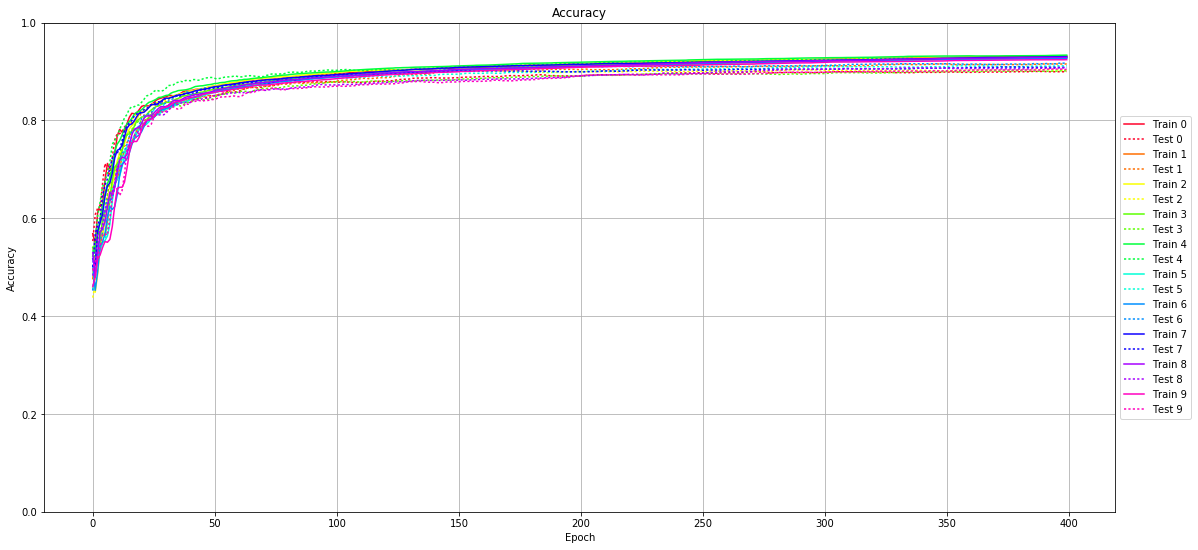

In [14]:
plot_acc(history)

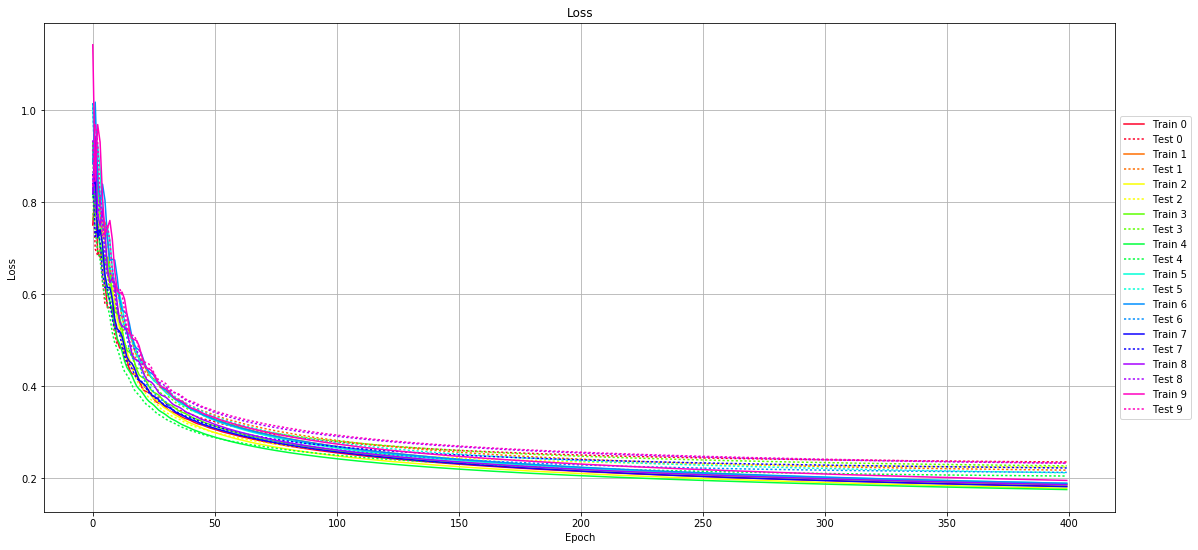

In [15]:
plot_loss(history)

In [16]:
# Viewing the confusion matrix
conf_mat = conf_mat.T  # since rows and cols are interchangeable
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix

Plotting the confusion matrix


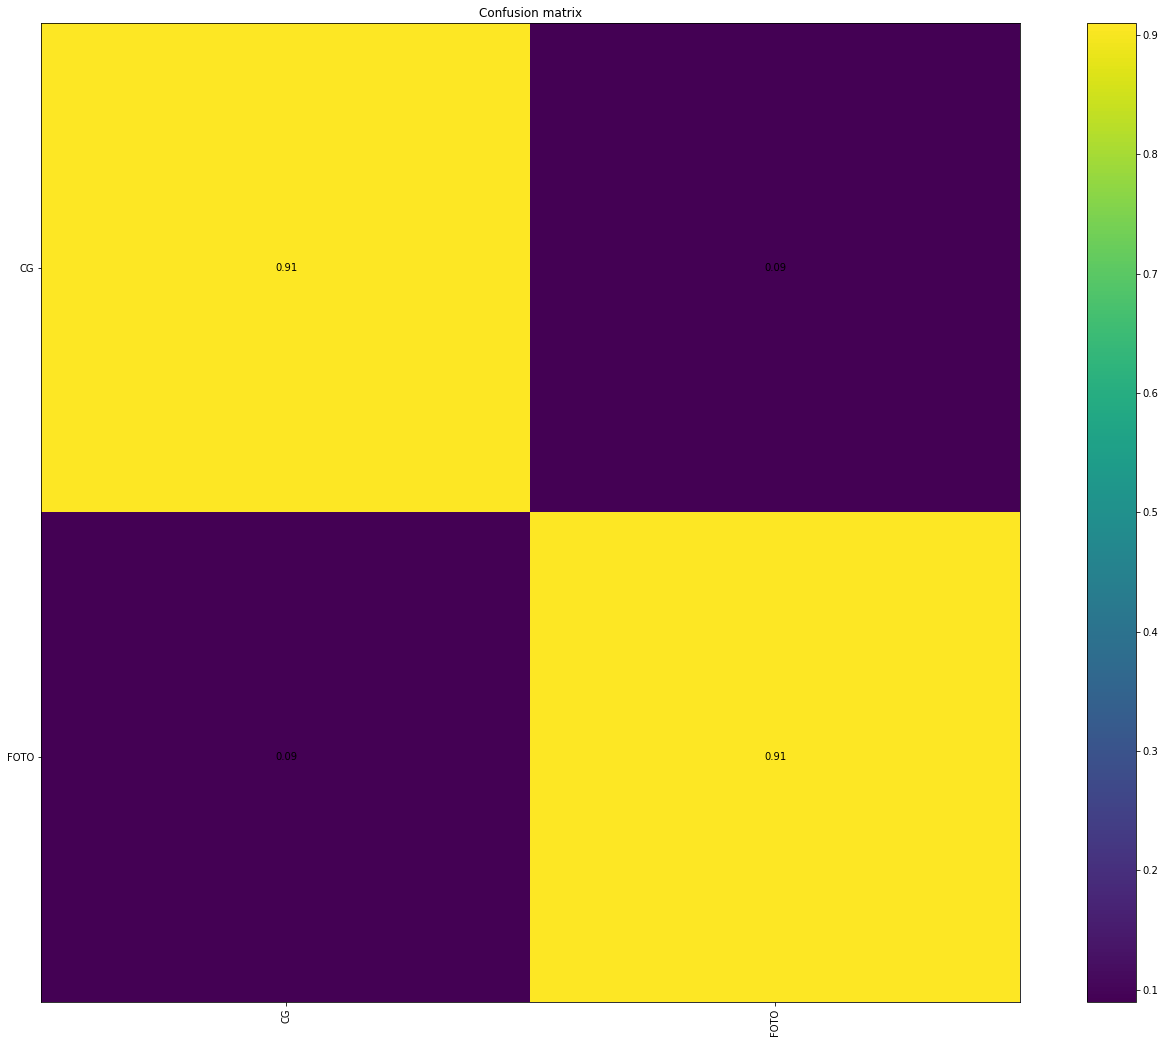

In [17]:
print("Plotting the confusion matrix")
conf_mat = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(24, 18)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.title('Confusion matrix')
plt.colorbar()
plt.show()